In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance, plot_tree, to_graphviz

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import Normalizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_init = pd.read_csv('data-last.csv', sep=';')
df_init.head()

,Id,Result,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_109,Feature_110,Feature_111,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117,Feature_118
0,1,2,2,56,12,1,7.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,1,1,0
1,2,2,2,69,19,1,6.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,1
2,3,2,1,66,8,1,4.0,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0
3,4,2,2,62,16,1,NaN,3.0,0,1.0,...,1.0,0.0,1,0,1,1,0,0,1,1
4,5,2,2,67,30,1,NaN,4.0,0,1.0,...,1.0,0.0,1,0,1,1,1,0,1,0


In [3]:
df = df_init.copy()

target_feature = 'Result'
golden_features = ['Feature_3', 'Feature_4', 'Feature_30', 'Feature_32', 'Feature_35', 'Feature_101']
trash_features = [] #feature_importances[feature_importances['importance'] < 0.007870]['feature_name'].tolist()
all_features = df.columns.drop([target_feature] + golden_features + trash_features + ['Id']).tolist()

df = df[[target_feature] + all_features]

cat_features = df.select_dtypes(include='int64').columns.drop([target_feature]).tolist()

for col in df.select_dtypes(include='float64').columns:
    df.fillna(df[col].mean(), inplace=True)

for col in df.select_dtypes(include='int64').columns:
    df.fillna(-99, inplace=True)

# Result=0 - alive, Result=1 died
df.loc[df[target_feature] == 1, target_feature] = 1
df.loc[df[target_feature] == 2, target_feature] = 0

In [4]:
X = df[all_features]
y = df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    test_size=0.1,
    random_state=0,
    stratify=y
)

params_frozen = {
    "objective": "reg:logistic",
    "eval_metric": "error",
    "missing": -99,
    "verbosity": 1,
}

params_grid = {
    "n_estimators": [50, 100, 200],
    "lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.2],
    "learning_rate": [0.1, 0.3, 0.5],
    "max_depth": [4, 6, 8],
}

clf=XGBClassifier(**params_frozen)
gs = GridSearchCV(
    clf,
    params_grid,
    cv=5,
)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='error',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=-99, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='reg:logistic',
                                     random_state=None, reg_alpha=None,
                          

In [5]:
clf_final=XGBClassifier(**params_frozen, **gs.best_params_)
clf_final.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False,
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0.2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=1, learning_rate=0.1,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=-99,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [6]:
y_test_pred = clf_final.predict(X_test)

print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')
print(f'\nConfusion matrix:\n {confusion_matrix(y_test, y_test_pred)}')

Accuracy: 0.87

Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.80      0.80      0.80         5

    accuracy                           0.87        15
   macro avg       0.85      0.85      0.85        15
weighted avg       0.87      0.87      0.87        15


Confusion matrix:
 [[9 1]
 [1 4]]


In [7]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf_final.feature_importances_),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(50)

,feature_name,importance
20,Feature_23,0.092827
93,Feature_99,0.076846
105,Feature_116,0.073337
35,Feature_41,0.070905
48,Feature_54,0.050177
38,Feature_44,0.047124
15,Feature_18,0.039928
46,Feature_52,0.038924
14,Feature_17,0.035709
26,Feature_29,0.035258


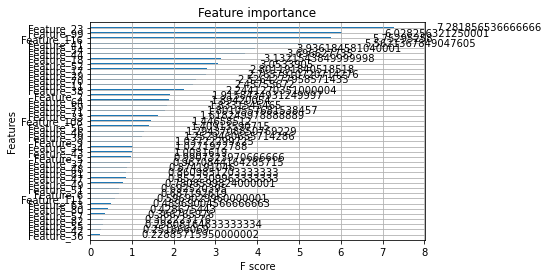

In [8]:
plot_importance(
    booster=clf_final,
    importance_type='gain'
)

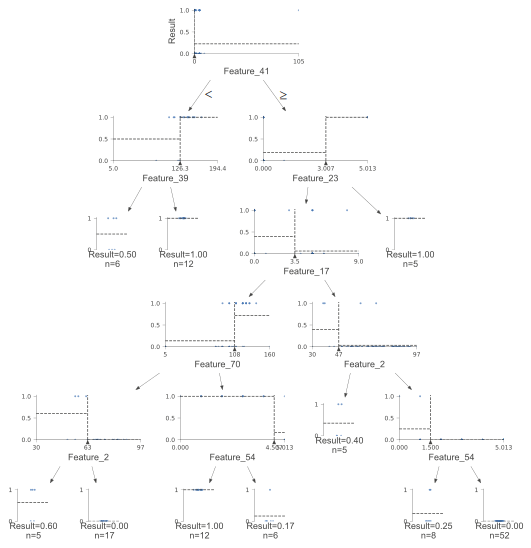

In [9]:
from dtreeviz.models.xgb_decision_tree import ShadowXGBDTree
from dtreeviz import trees

xgb_shadow = ShadowXGBDTree(
    booster=clf_final,
    tree_index=1,
    x_data=X_train,
    y_data=y_train,
    feature_names=all_features,
    target_name=target_feature,
    class_names=[0, 1])

trees.dtreeviz(xgb_shadow)